In [19]:
# Celda 1: Imports
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import json

In [20]:
# Celda 2: Carga de datasets y parámetros
# Cargar datasets
df_codigos = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_codigos.csv", on_bad_lines='skip', delimiter='|')
df_descr = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_descripciones.csv", on_bad_lines='skip', delimiter='|')
df_comb = pd.read_csv(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\diagnosticos_binarios_combinados.csv", on_bad_lines='skip', delimiter='|')

datasets = {
    "codigos": df_codigos,
    "descripciones": df_descr,
    "combinado": df_comb
}

# Cargar parámetros desde JSON
with open(r"C:\Users\Usuario\Documents\Workspace\Estudio-Psiquiatricos\TFG\dataset\tree_params.json", "r") as f:
    all_params = json.load(f)

print("✅ Datasets y parámetros cargados exitosamente")
print(f"📊 Datasets disponibles: {list(datasets.keys())}")

✅ Datasets y parámetros cargados exitosamente
📊 Datasets disponibles: ['codigos', 'descripciones', 'combinado']


In [21]:
# Celda 3: Función para analizar modelo con SHAP (CORREGIDA CON GUARDADO)
def analizar_modelo_shap(df, nombre_dataset, model_class, model_name, params):
    print(f"\n📌 Analizando con {model_name} en dataset: {nombre_dataset}")
    print(f"🔧 Parámetros utilizados: {params}")
    
    # Crear directorio para guardar gráficas
    import os
    output_dir = f"shap_plots/{nombre_dataset}_{model_name.replace(' ', '_')}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Preparar datos
    # Combinar todas las columnas excepto la de la etiqueta en un solo texto
    text_columns = [col for col in df.columns if col != 'DIAG PSQ']
    X = df[text_columns].fillna('').astype(str).agg(' '.join, axis=1)
    
    # Preparar la variable objetivo según el dataset
    if nombre_dataset == "codigos":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20" in str(x) and "F20.89" not in str(x) else 0)
    elif nombre_dataset == "descripciones":
        y = df['DIAG PSQ'].apply(lambda x: 1 if "Esquizofrenia" in str(x) and "Otros tipos de esquizofrenia" not in str(x) else 0)
    else:  # combinado
        y = df['DIAG PSQ'].apply(lambda x: 1 if "F20.89" in str(x) else 0)
    
    print(f"📈 Distribución de clases: {y.value_counts().to_dict()}")
    
    # Vectorización de texto con configuración más robusta
    vectorizer = TfidfVectorizer(
        max_features=500,  # Reducir features para mejor rendimiento
        stop_words='english',
        dtype=np.float32  # Especificar dtype explícitamente
    )
    X_vect = vectorizer.fit_transform(X)
    
    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_vect, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Crear modelo con parámetros específicos
    model = model_class(**params)
    
    # Entrenamiento
    print("🚀 Entrenando modelo...")
    model.fit(X_train, y_train)
    
    # Calcular accuracy para verificar
    accuracy = model.score(X_test, y_test)
    print(f"✅ Accuracy del modelo: {accuracy:.4f}")
    
    # SHAP explainer
    print("🔎 Generando explicaciones SHAP...")
    try:
        # Convertir matrices sparse a arrays densos con dtype correcto
        n_samples = min(50, X_test.shape[0])  # Usar máximo 50 muestras
        X_test_dense = X_test[:n_samples].toarray().astype(np.float32)
        feature_names = vectorizer.get_feature_names_out()
        
        print(f"📊 Forma de datos para SHAP: {X_test_dense.shape}, dtype: {X_test_dense.dtype}")
        
        if model_name in ["Random Forest", "Gradient Boosting"]:
            # TreeExplainer para modelos basados en árboles
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test_dense)
            
            print(f"📊 SHAP values tipo: {type(shap_values)}")
            print(f"📊 SHAP values shape: {np.array(shap_values).shape}")
            
            # Manejar diferentes formatos de SHAP values
            if isinstance(shap_values, list) and len(shap_values) == 2:
                # Formato lista con 2 elementos (una matriz por clase)
                shap_values_plot = shap_values[1]  # Clase positiva
                print(f"📊 Usando clase positiva (índice 1): {shap_values_plot.shape}")
            elif isinstance(shap_values, np.ndarray):
                if shap_values.ndim == 3 and shap_values.shape[-1] == 2:
                    # Formato 3D (n_samples, n_features, n_classes)
                    shap_values_plot = shap_values[:, :, 1]  # Clase positiva
                    print(f"📊 Extraída clase positiva de array 3D: {shap_values_plot.shape}")
                elif shap_values.ndim == 2:
                    # Formato 2D (n_samples, n_features)
                    shap_values_plot = shap_values
                    print(f"📊 Array 2D directo: {shap_values_plot.shape}")
                else:
                    print(f"⚠️  Formato de array inesperado: shape {shap_values.shape}")
                    return model, accuracy
            else:
                print(f"⚠️  Formato de shap_values inesperado: {type(shap_values)}")
                return model, accuracy
            
            # Verificar que shap_values_plot tiene la forma correcta (2D)
            if shap_values_plot.ndim != 2:
                print(f"⚠️  SHAP values finales no son 2D: {shap_values_plot.shape}")
                return model, accuracy
            
            print(f"✅ SHAP values finales: {shap_values_plot.shape}")
            
            # 1. Gráfica resumen (Summary Plot)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values_plot, 
                X_test_dense, 
                feature_names=feature_names,
                show=False, 
                max_display=15,
                plot_type="dot"
            )
            plt.title(f'SHAP Summary - {model_name} ({nombre_dataset})', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f"{output_dir}/summary_plot.png", dpi=300, bbox_inches='tight')
            plt.show()
            print(f"💾 Summary plot guardado en: {output_dir}/summary_plot.png")
            
            # 2. Gráfica de importancia de características (Bar Plot)
            plt.figure(figsize=(10, 6))
            feature_importance = np.abs(shap_values_plot).mean(0)
            print(f"📊 Feature importance shape: {feature_importance.shape}")
            
            if feature_importance.ndim == 1 and len(feature_importance) > 0:
                top_indices = np.argsort(feature_importance)[-15:]
                
                plt.barh(range(len(top_indices)), feature_importance[top_indices])
                plt.yticks(range(len(top_indices)), feature_names[top_indices])
                plt.xlabel('Mean |SHAP Value|')
                plt.title(f'Feature Importance - {model_name} ({nombre_dataset})')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/feature_importance.png", dpi=300, bbox_inches='tight')
                plt.show()
                print(f"💾 Feature importance guardado en: {output_dir}/feature_importance.png")
            else:
                print(f"⚠️  No se puede crear gráfico de importancia: shape {feature_importance.shape}")
            
            # 3. Waterfall plot para las primeras 3 muestras
            print("🌊 Generando Waterfall plots...")
            for i in range(min(3, shap_values_plot.shape[0])):
                plt.figure(figsize=(12, 8))
                
                # Crear un objeto Explanation para waterfall
                explanation = shap.Explanation(
                    values=shap_values_plot[i],
                    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                    data=X_test_dense[i],
                    feature_names=feature_names
                )
                
                shap.waterfall_plot(explanation, max_display=15, show=False)
                plt.title(f'Waterfall Plot - {model_name} ({nombre_dataset}) - Muestra {i+1}', 
                         fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/waterfall_sample_{i+1}.png", dpi=300, bbox_inches='tight')
                plt.show()
                print(f"💾 Waterfall plot muestra {i+1} guardado en: {output_dir}/waterfall_sample_{i+1}.png")
            
        else:  # XGBoost
            # Para XGBoost, usar background data más pequeño
            n_background = min(100, X_train.shape[0])
            X_train_dense = X_train[:n_background].toarray().astype(np.float32)
            
            print(f"📊 Background data shape: {X_train_dense.shape}")
            
            explainer = shap.Explainer(model, X_train_dense)
            shap_values = explainer(X_test_dense)
            
            print(f"📊 SHAP explanation shape: {shap_values.values.shape}")
            
            # 1. Gráfica resumen (Summary Plot)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values, 
                X_test_dense, 
                feature_names=feature_names,
                show=False, 
                max_display=15
            )
            plt.title(f'SHAP Summary - {model_name} ({nombre_dataset})', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f"{output_dir}/summary_plot.png", dpi=300, bbox_inches='tight')
            plt.show()
            print(f"💾 Summary plot guardado en: {output_dir}/summary_plot.png")
            
            # 2. Gráfica de importancia (Bar Plot)
            plt.figure(figsize=(10, 6))
            shap.plots.bar(shap_values, max_display=15, show=False)
            plt.title(f'Feature Importance - {model_name} ({nombre_dataset})')
            plt.tight_layout()
            plt.savefig(f"{output_dir}/feature_importance.png", dpi=300, bbox_inches='tight')
            plt.show()
            print(f"💾 Feature importance guardado en: {output_dir}/feature_importance.png")
            
            # 3. Waterfall plots para las primeras 3 muestras
            print("🌊 Generando Waterfall plots...")
            for i in range(min(3, len(shap_values))):
                plt.figure(figsize=(12, 8))
                shap.waterfall_plot(shap_values[i], max_display=15, show=False)
                plt.title(f'Waterfall Plot - {model_name} ({nombre_dataset}) - Muestra {i+1}', 
                         fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.savefig(f"{output_dir}/waterfall_sample_{i+1}.png", dpi=300, bbox_inches='tight')
                plt.show()
                print(f"💾 Waterfall plot muestra {i+1} guardado en: {output_dir}/waterfall_sample_{i+1}.png")
        
    except Exception as e:
        print(f"❌ Error generando SHAP: {e}")
        print(f"Tipo de error: {type(e).__name__}")
        import traceback
        print(f"Detalles del error:\n{traceback.format_exc()}")
    
    return model, accuracy

In [22]:
# Celda 4: Mapeo de clases de modelos
# Define modelos a probar
model_classes = {
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": XGBClassifier,
    "GradientBoostingClassifier": GradientBoostingClassifier
}

model_names = {
    "RandomForestClassifier": "Random Forest",
    "XGBClassifier": "XGBoost", 
    "GradientBoostingClassifier": "Gradient Boosting"
}

print("🔧 Modelos configurados:")
for model_key in model_classes.keys():
    print(f"• {model_names[model_key]} ({model_key})")

🔧 Modelos configurados:
• Random Forest (RandomForestClassifier)
• XGBoost (XGBClassifier)
• Gradient Boosting (GradientBoostingClassifier)



🎯 PROCESANDO DATASET: CODIGOS

📌 Analizando con Random Forest en dataset: codigos
🔧 Parámetros utilizados: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 300, 'max_depth': 30, 'random_state': 42}
📈 Distribución de clases: {0: 1385, 1: 612}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.7575
🔎 Generando explicaciones SHAP...
📊 Forma de datos para SHAP: (50, 500), dtype: float32
📊 SHAP values tipo: <class 'numpy.ndarray'>
📊 SHAP values shape: (50, 500, 2)
📊 Extraída clase positiva de array 3D: (50, 500)
✅ SHAP values finales: (50, 500)


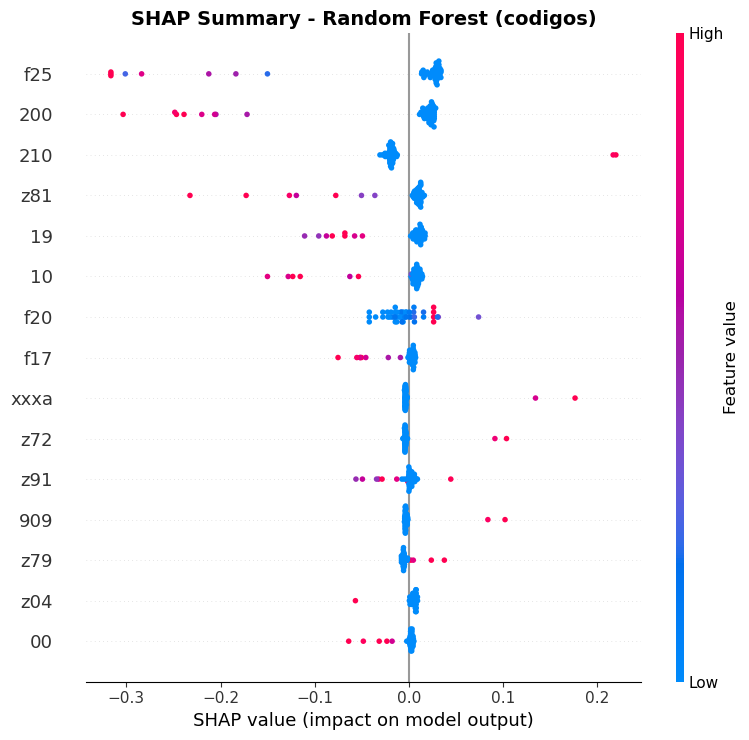

💾 Summary plot guardado en: shap_plots/codigos_Random_Forest/summary_plot.png
📊 Feature importance shape: (500,)


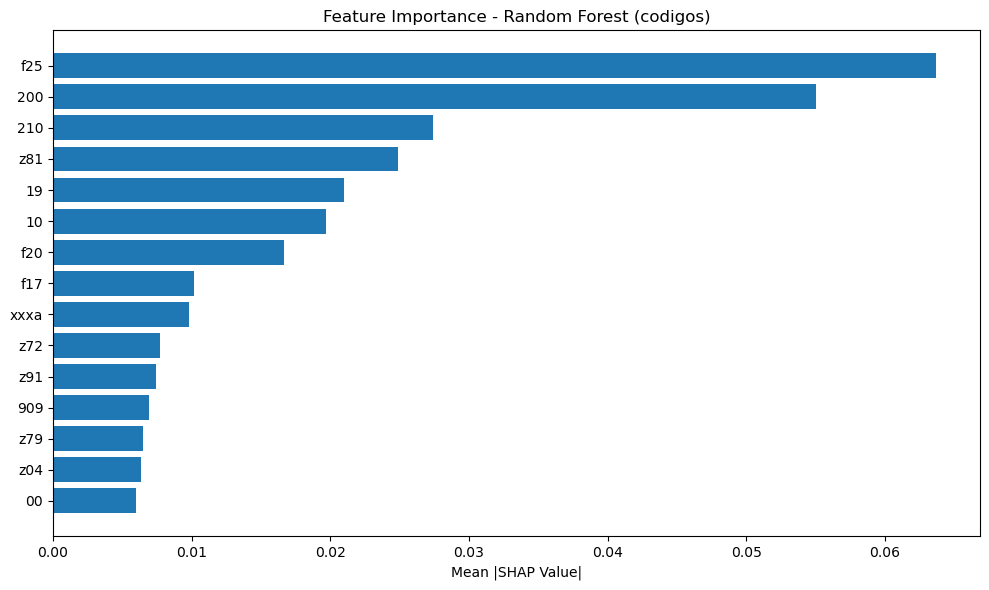

💾 Feature importance guardado en: shap_plots/codigos_Random_Forest/feature_importance.png
🌊 Generando Waterfall plots...


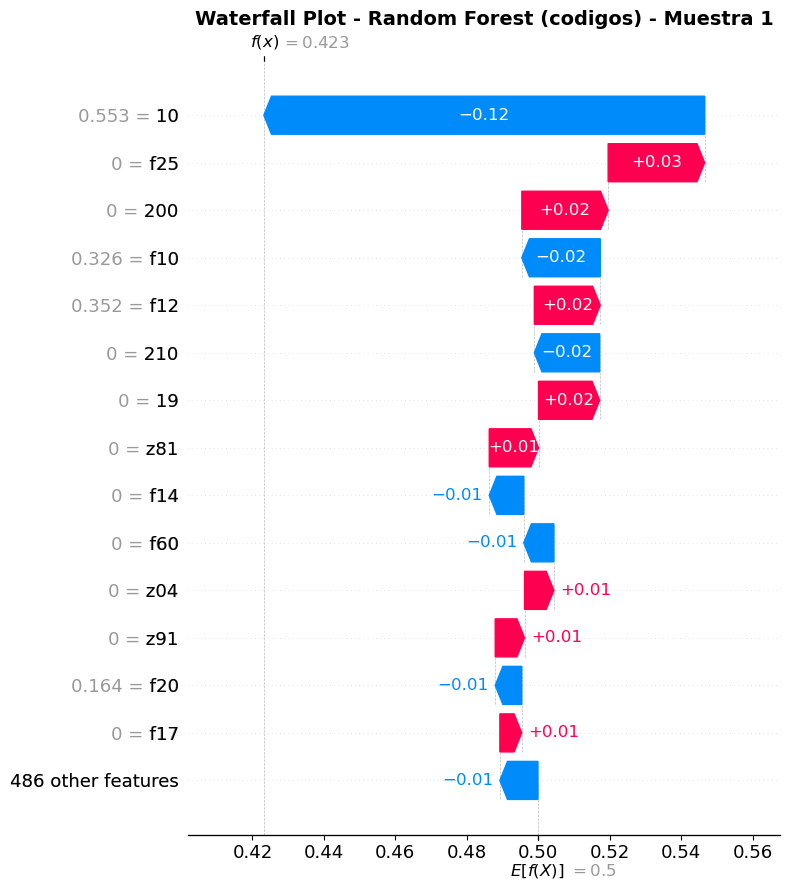

💾 Waterfall plot muestra 1 guardado en: shap_plots/codigos_Random_Forest/waterfall_sample_1.png


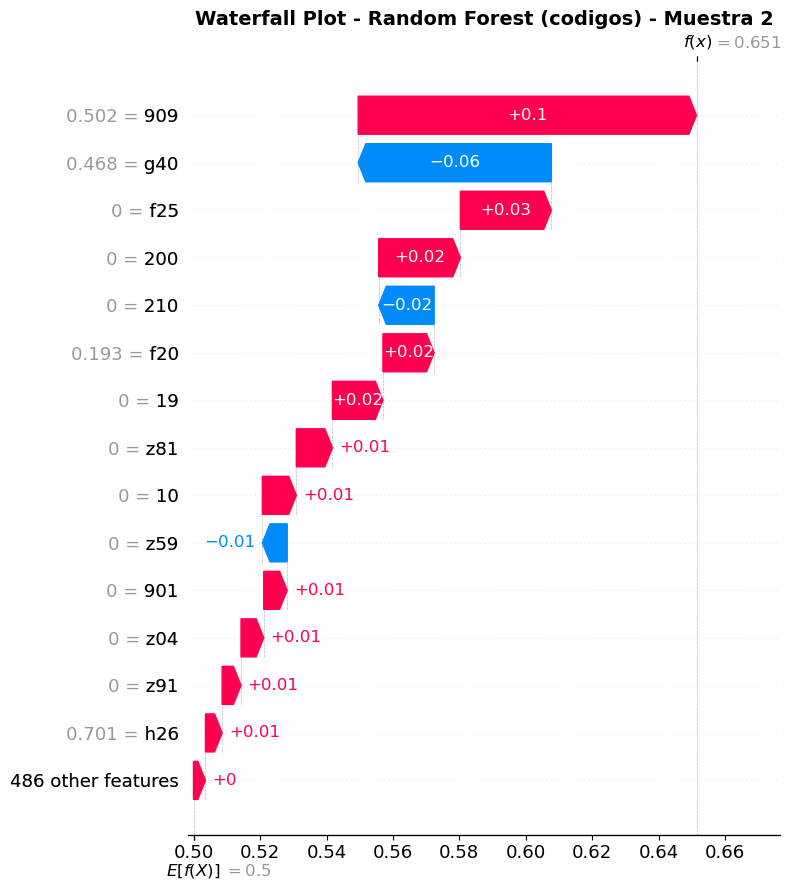

💾 Waterfall plot muestra 2 guardado en: shap_plots/codigos_Random_Forest/waterfall_sample_2.png


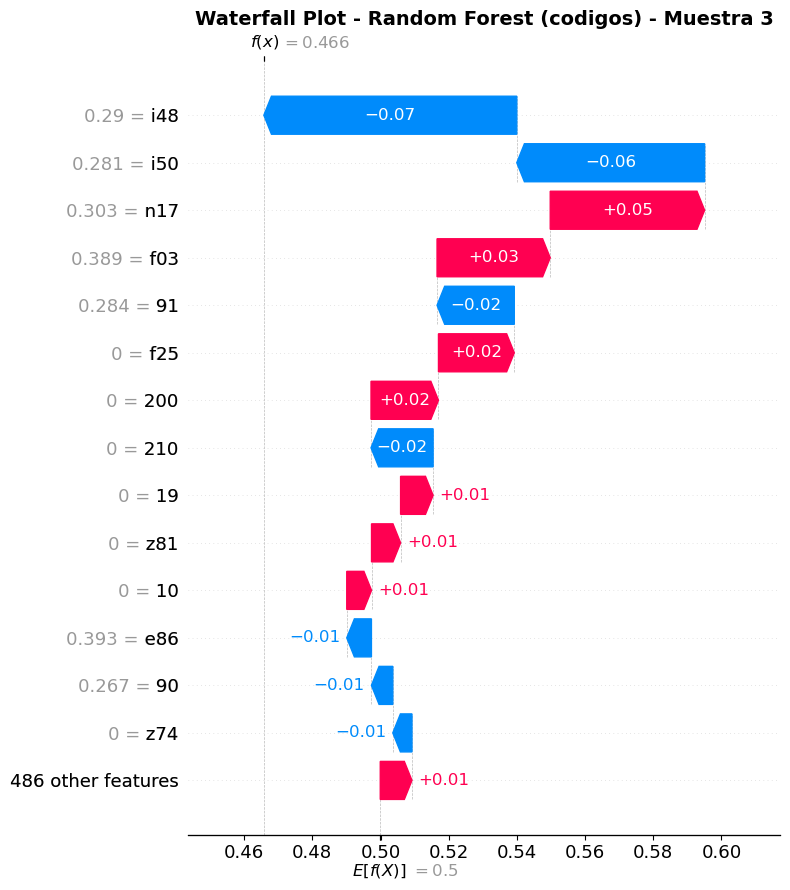

💾 Waterfall plot muestra 3 guardado en: shap_plots/codigos_Random_Forest/waterfall_sample_3.png

📌 Analizando con XGBoost en dataset: codigos
🔧 Parámetros utilizados: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'gamma': 0.5, 'scale_pos_weight': 2, 'random_state': 42}
📈 Distribución de clases: {0: 1385, 1: 612}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.7525
🔎 Generando explicaciones SHAP...
📊 Forma de datos para SHAP: (50, 500), dtype: float32
📊 Background data shape: (100, 500)
📊 SHAP explanation shape: (50, 500)


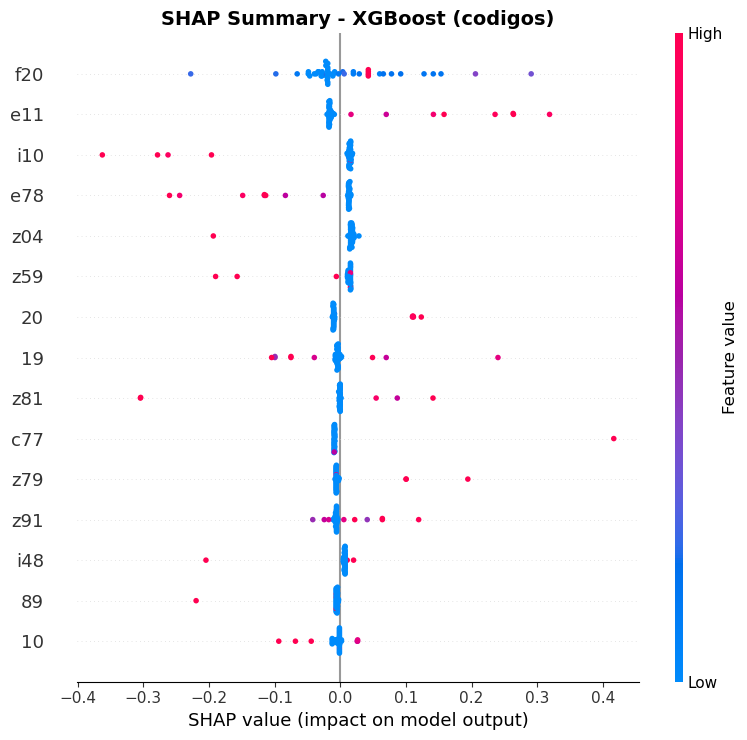

💾 Summary plot guardado en: shap_plots/codigos_XGBoost/summary_plot.png


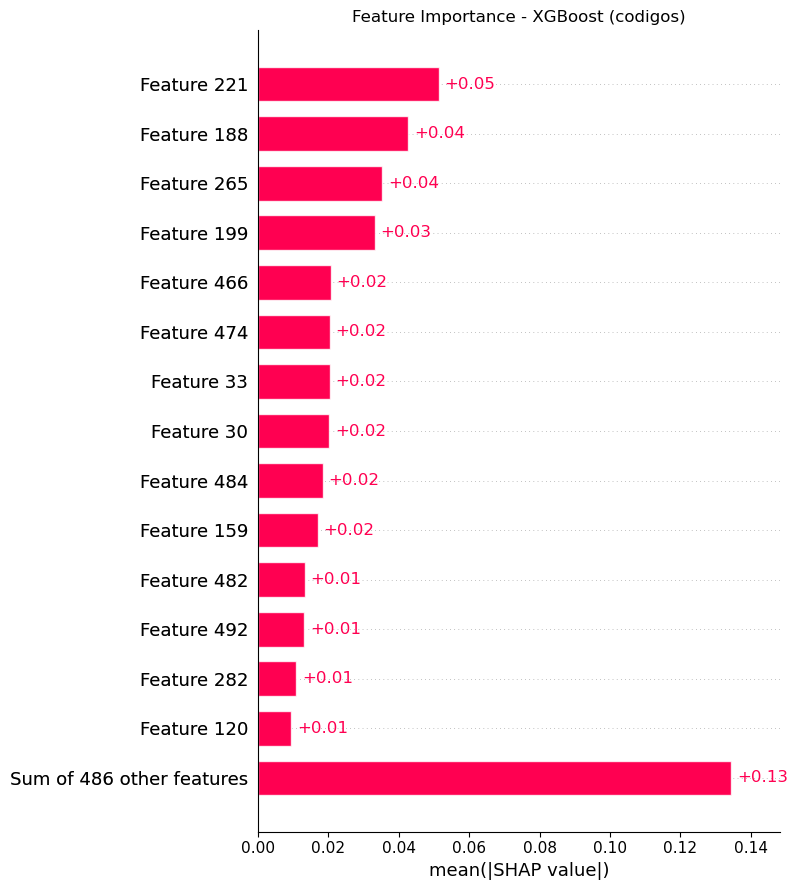

💾 Feature importance guardado en: shap_plots/codigos_XGBoost/feature_importance.png
🌊 Generando Waterfall plots...


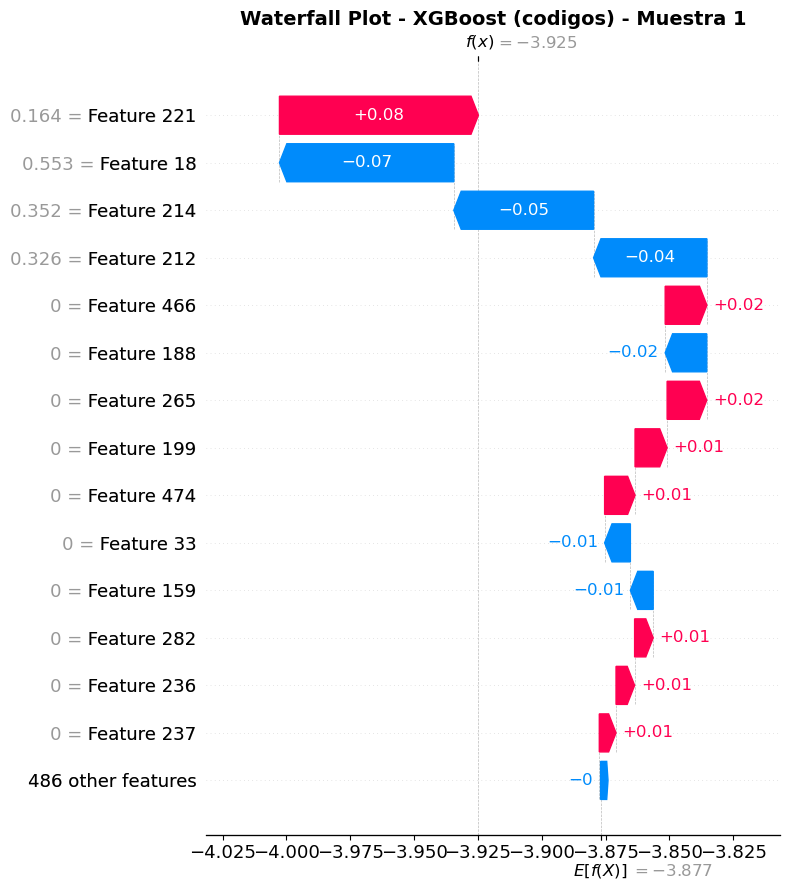

💾 Waterfall plot muestra 1 guardado en: shap_plots/codigos_XGBoost/waterfall_sample_1.png


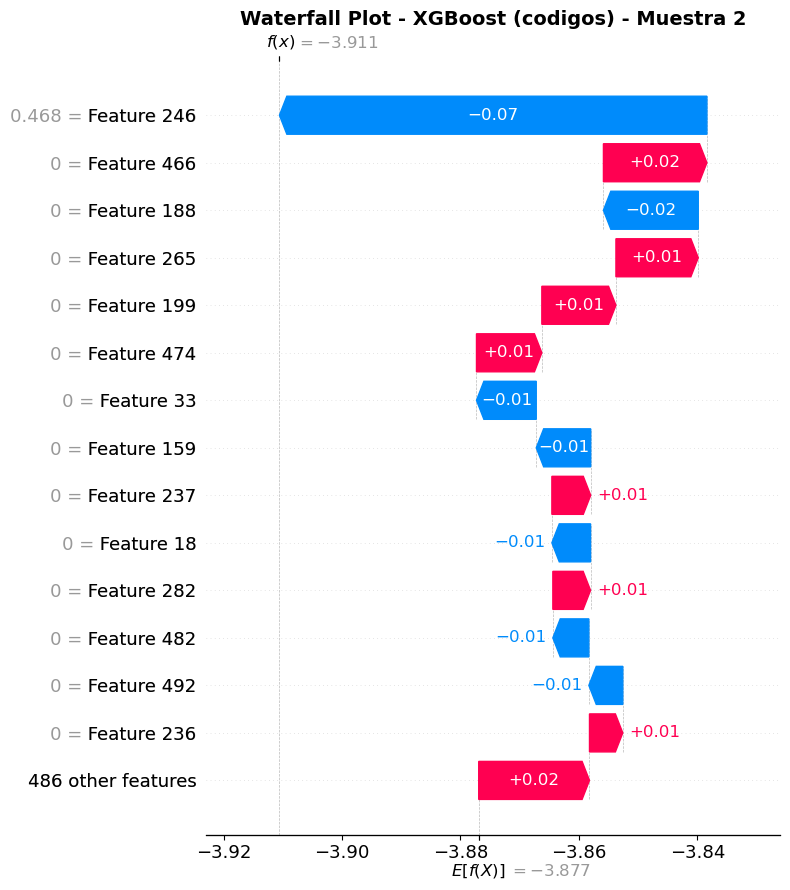

💾 Waterfall plot muestra 2 guardado en: shap_plots/codigos_XGBoost/waterfall_sample_2.png


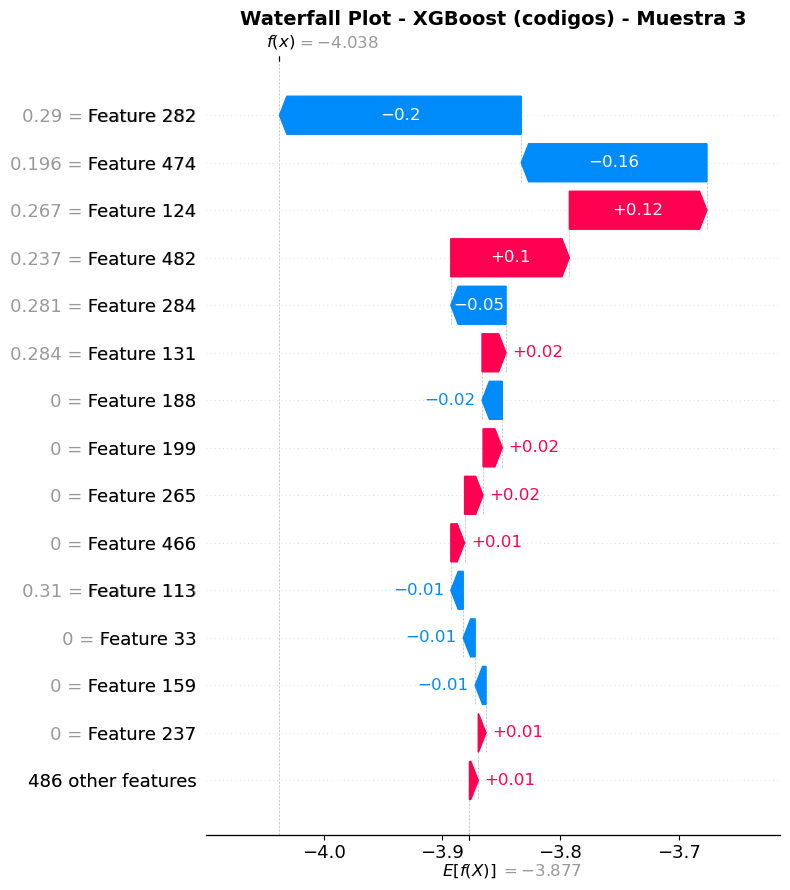

💾 Waterfall plot muestra 3 guardado en: shap_plots/codigos_XGBoost/waterfall_sample_3.png

📌 Analizando con Gradient Boosting en dataset: codigos
🔧 Parámetros utilizados: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'random_state': 42, 'min_samples_split': 10, 'min_samples_leaf': 2, 'subsample': 1, 'max_features': None}
📈 Distribución de clases: {0: 1385, 1: 612}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.8050
🔎 Generando explicaciones SHAP...
📊 Forma de datos para SHAP: (50, 500), dtype: float32
📊 SHAP values tipo: <class 'numpy.ndarray'>
📊 SHAP values shape: (50, 500)
📊 Array 2D directo: (50, 500)
✅ SHAP values finales: (50, 500)


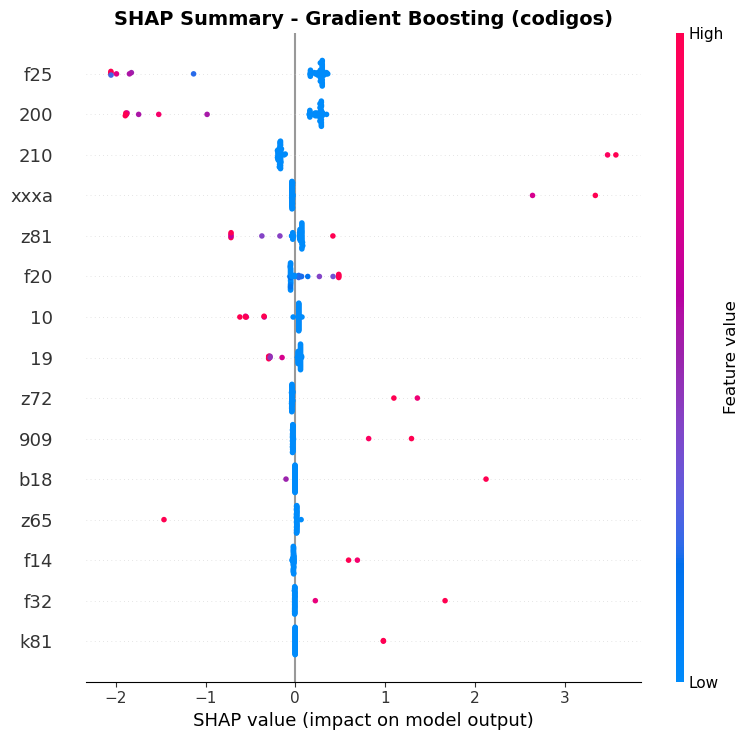

💾 Summary plot guardado en: shap_plots/codigos_Gradient_Boosting/summary_plot.png
📊 Feature importance shape: (500,)


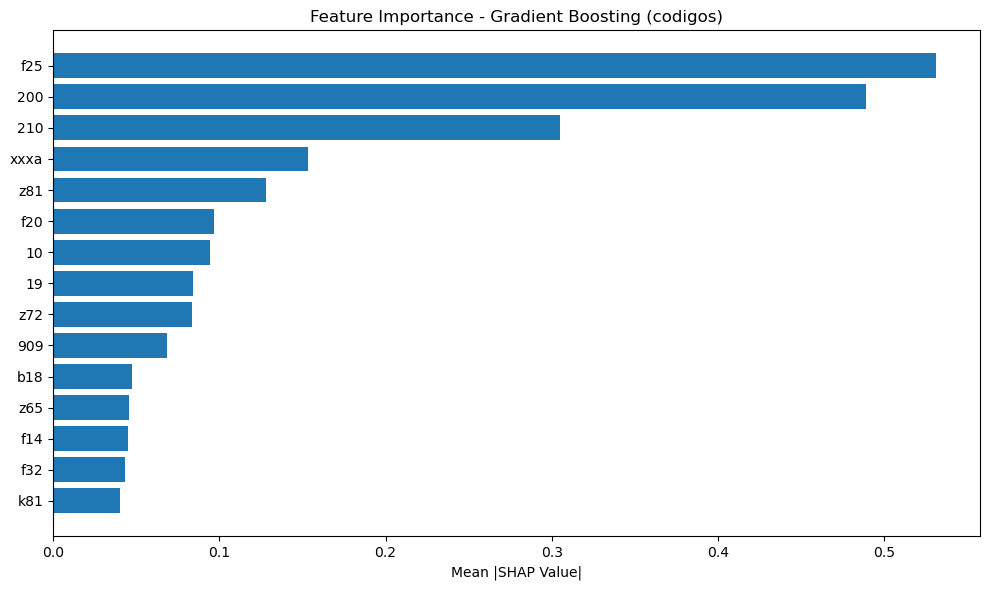

💾 Feature importance guardado en: shap_plots/codigos_Gradient_Boosting/feature_importance.png
🌊 Generando Waterfall plots...
❌ Error generando SHAP: index 1 is out of bounds for axis 0 with size 1
Tipo de error: IndexError
Detalles del error:
Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_25396\664267579.py", line 139, in analizar_modelo_shap
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                ~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


🎯 PROCESANDO DATASET: DESCRIPCIONES

📌 Analizando con Random Forest en dataset: descripciones
🔧 Parámetros utilizados: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 300, 'max_depth': 30, 'random_state': 42}
📈 Distribución de clases: {0: 1394, 1: 603}
🚀 Entren

<Figure size 1200x800 with 0 Axes>

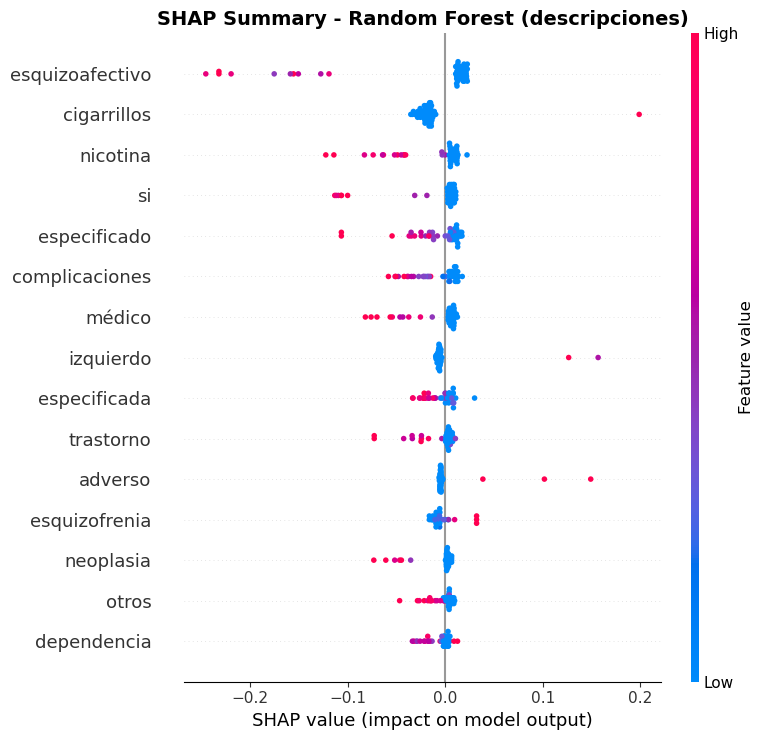

💾 Summary plot guardado en: shap_plots/descripciones_Random_Forest/summary_plot.png
📊 Feature importance shape: (500,)


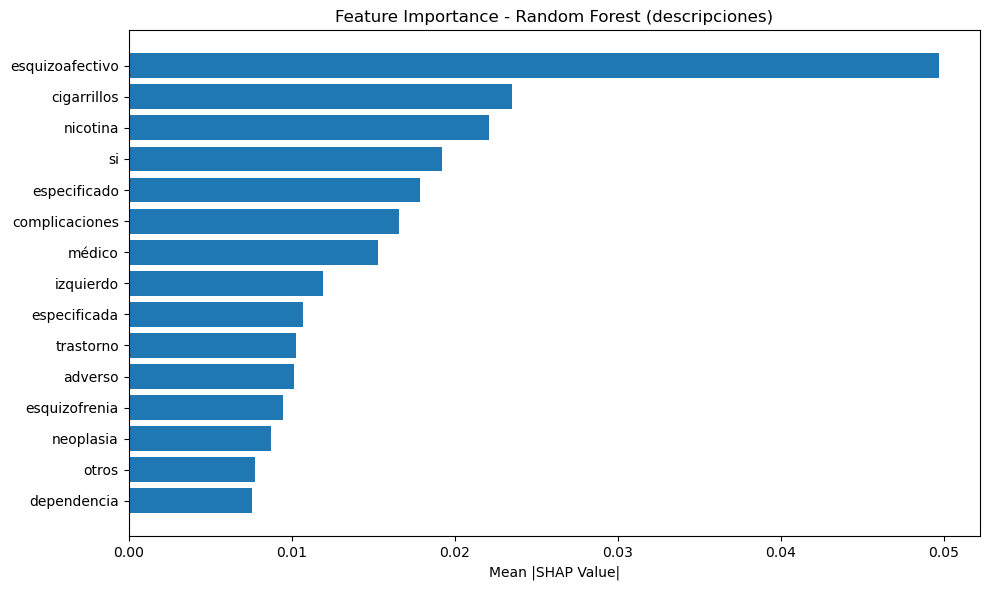

💾 Feature importance guardado en: shap_plots/descripciones_Random_Forest/feature_importance.png
🌊 Generando Waterfall plots...


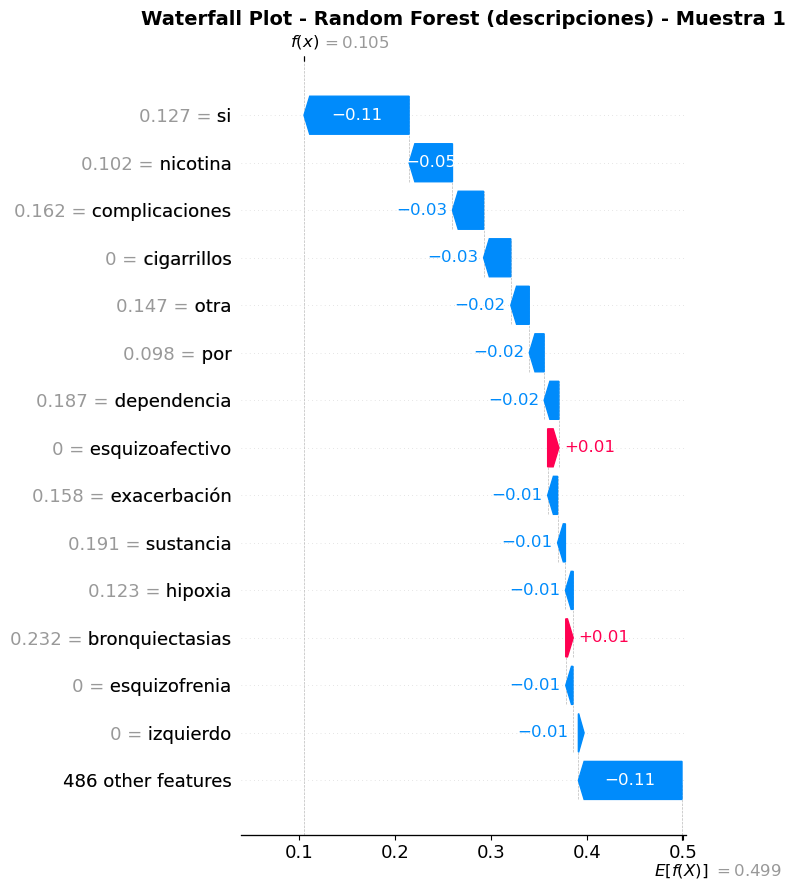

💾 Waterfall plot muestra 1 guardado en: shap_plots/descripciones_Random_Forest/waterfall_sample_1.png


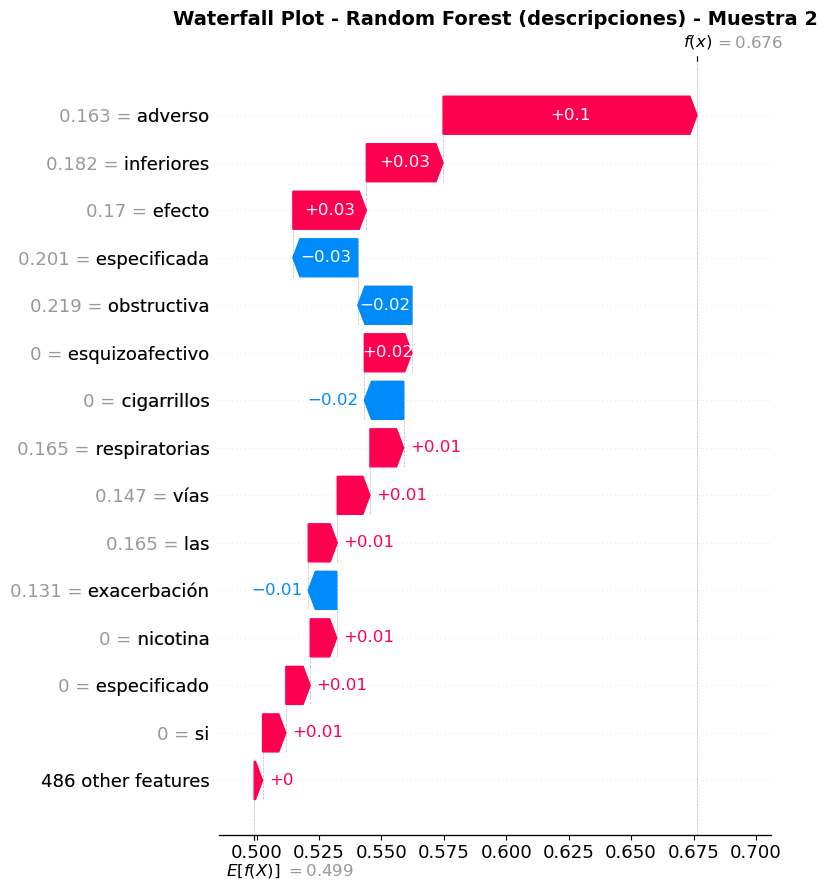

💾 Waterfall plot muestra 2 guardado en: shap_plots/descripciones_Random_Forest/waterfall_sample_2.png


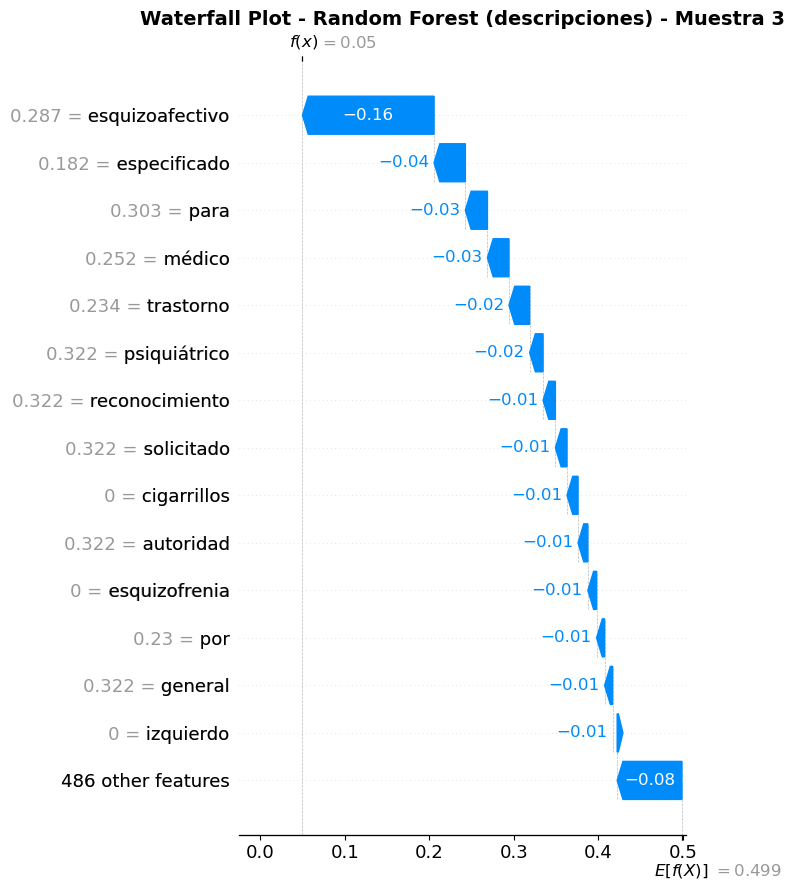

💾 Waterfall plot muestra 3 guardado en: shap_plots/descripciones_Random_Forest/waterfall_sample_3.png

📌 Analizando con XGBoost en dataset: descripciones
🔧 Parámetros utilizados: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'gamma': 0.2, 'scale_pos_weight': 2, 'random_state': 42}
📈 Distribución de clases: {0: 1394, 1: 603}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.8075
🔎 Generando explicaciones SHAP...
📊 Forma de datos para SHAP: (50, 500), dtype: float32
📊 Background data shape: (100, 500)
📊 SHAP explanation shape: (50, 500)


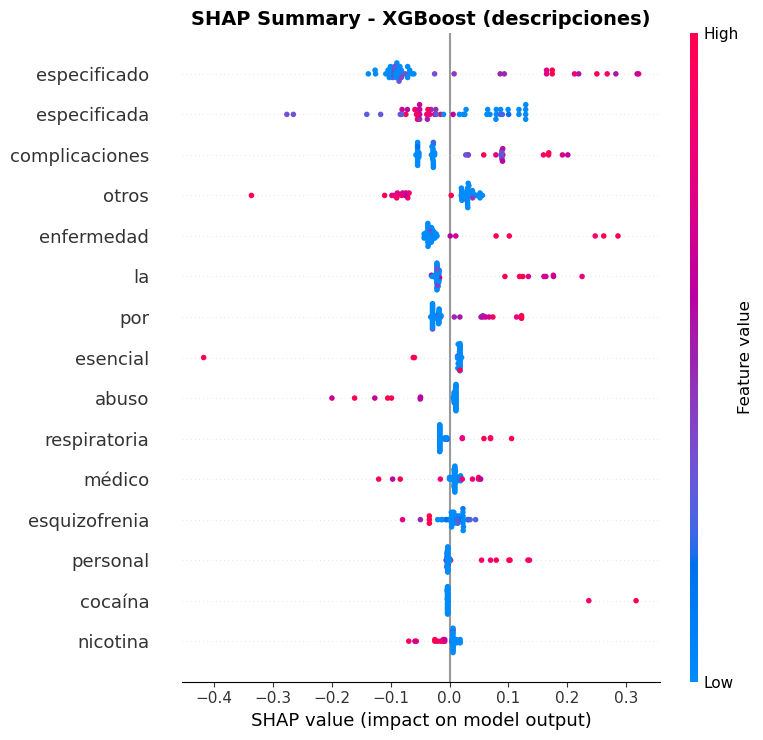

💾 Summary plot guardado en: shap_plots/descripciones_XGBoost/summary_plot.png


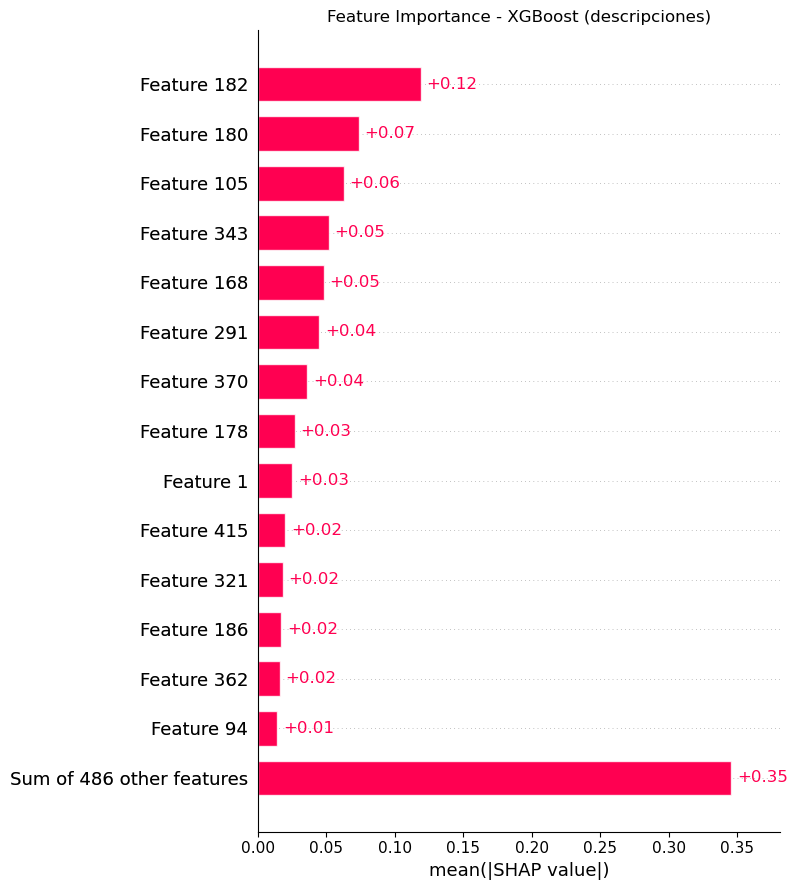

💾 Feature importance guardado en: shap_plots/descripciones_XGBoost/feature_importance.png
🌊 Generando Waterfall plots...


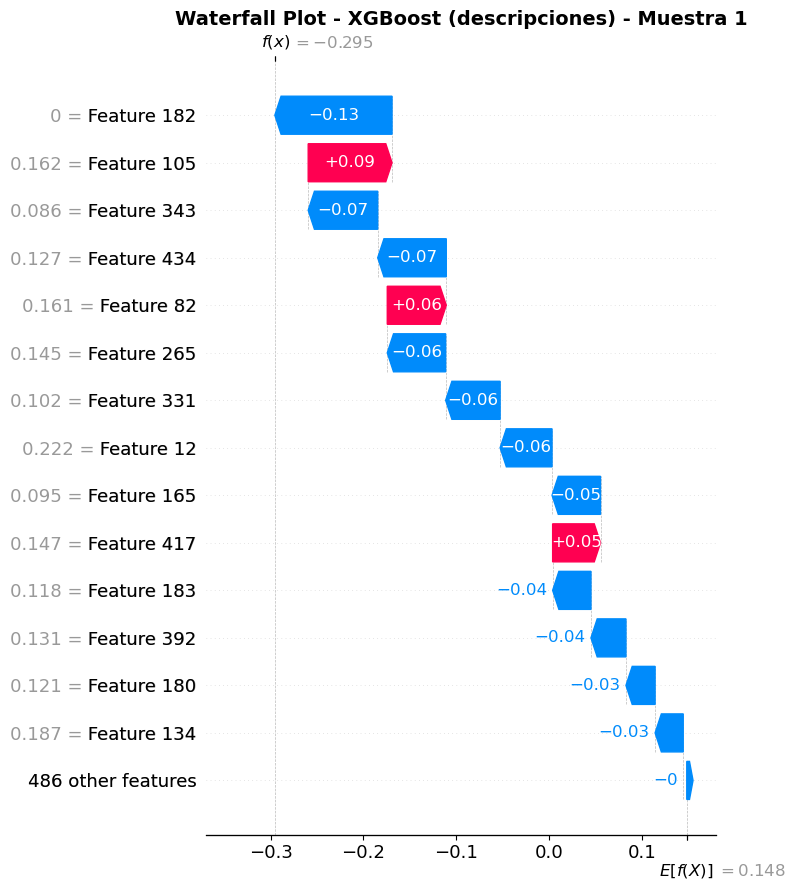

💾 Waterfall plot muestra 1 guardado en: shap_plots/descripciones_XGBoost/waterfall_sample_1.png


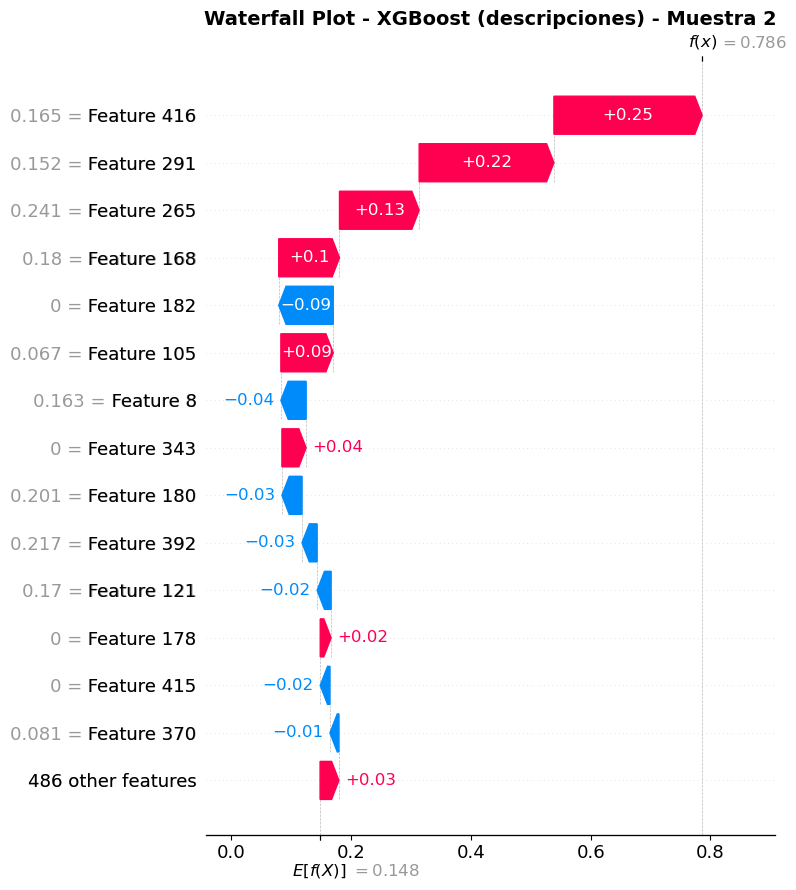

💾 Waterfall plot muestra 2 guardado en: shap_plots/descripciones_XGBoost/waterfall_sample_2.png


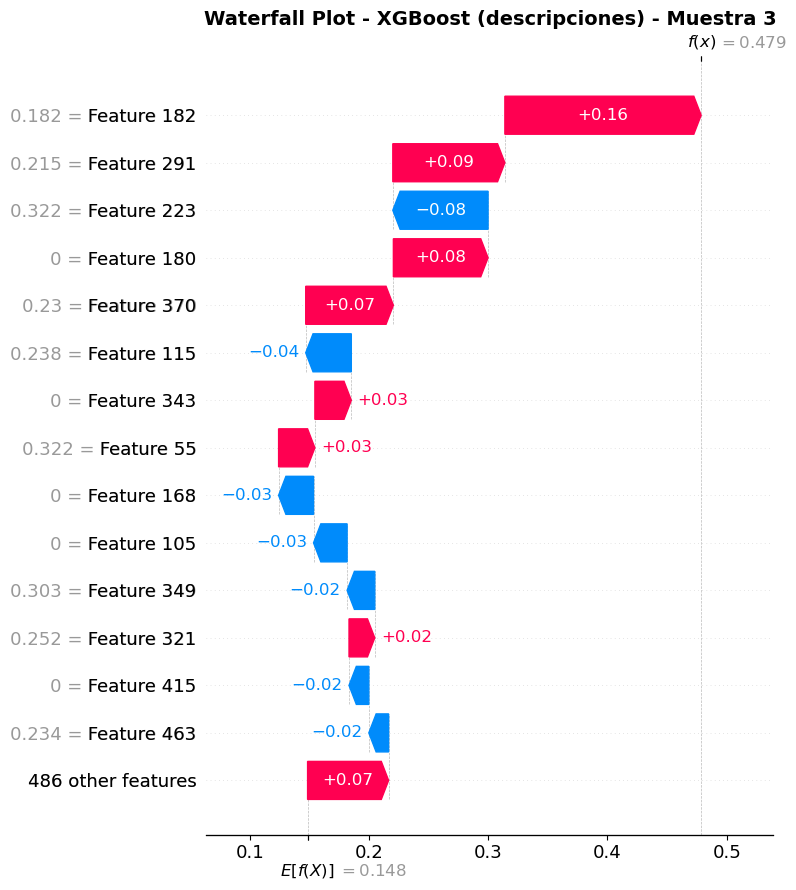

💾 Waterfall plot muestra 3 guardado en: shap_plots/descripciones_XGBoost/waterfall_sample_3.png

📌 Analizando con Gradient Boosting en dataset: descripciones
🔧 Parámetros utilizados: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 5, 'random_state': 42, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.8, 'max_features': None}
📈 Distribución de clases: {0: 1394, 1: 603}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.8025
🔎 Generando explicaciones SHAP...
📊 Forma de datos para SHAP: (50, 500), dtype: float32
📊 SHAP values tipo: <class 'numpy.ndarray'>
📊 SHAP values shape: (50, 500)
📊 Array 2D directo: (50, 500)
✅ SHAP values finales: (50, 500)


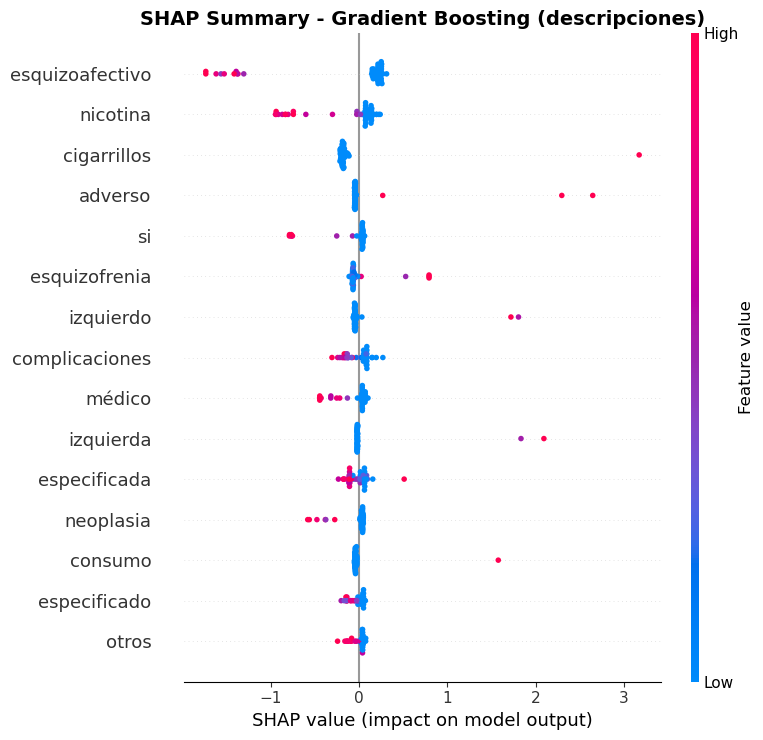

💾 Summary plot guardado en: shap_plots/descripciones_Gradient_Boosting/summary_plot.png
📊 Feature importance shape: (500,)


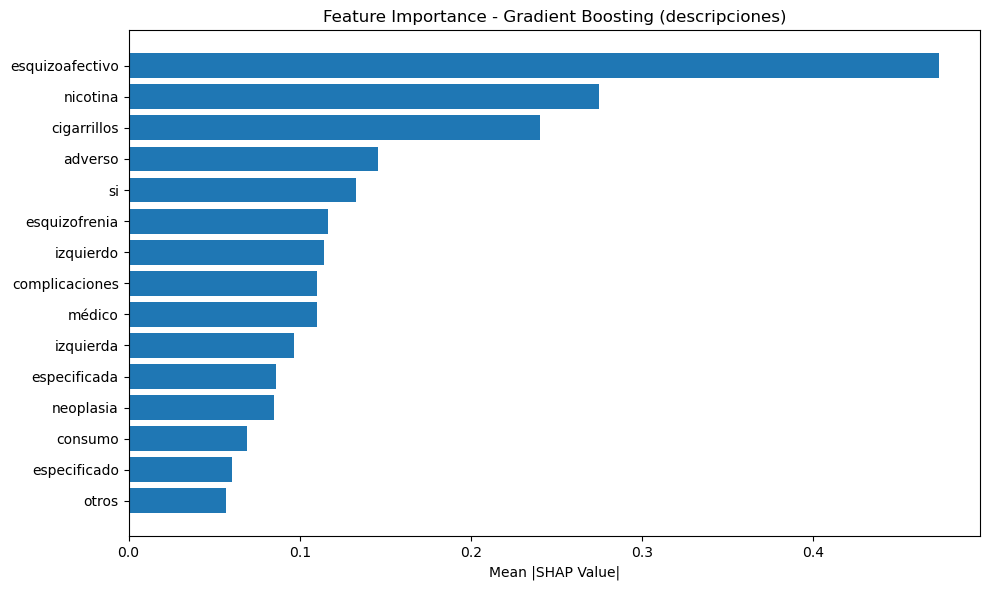

💾 Feature importance guardado en: shap_plots/descripciones_Gradient_Boosting/feature_importance.png
🌊 Generando Waterfall plots...
❌ Error generando SHAP: index 1 is out of bounds for axis 0 with size 1
Tipo de error: IndexError
Detalles del error:
Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_25396\664267579.py", line 139, in analizar_modelo_shap
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                ~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


🎯 PROCESANDO DATASET: COMBINADO

📌 Analizando con Random Forest en dataset: combinado
🔧 Parámetros utilizados: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 200, 'max_depth': 30, 'random_state': 42}
📈 Distribución de clases: {1: 1385, 0: 612}
🚀 Entrenan

<Figure size 1200x800 with 0 Axes>

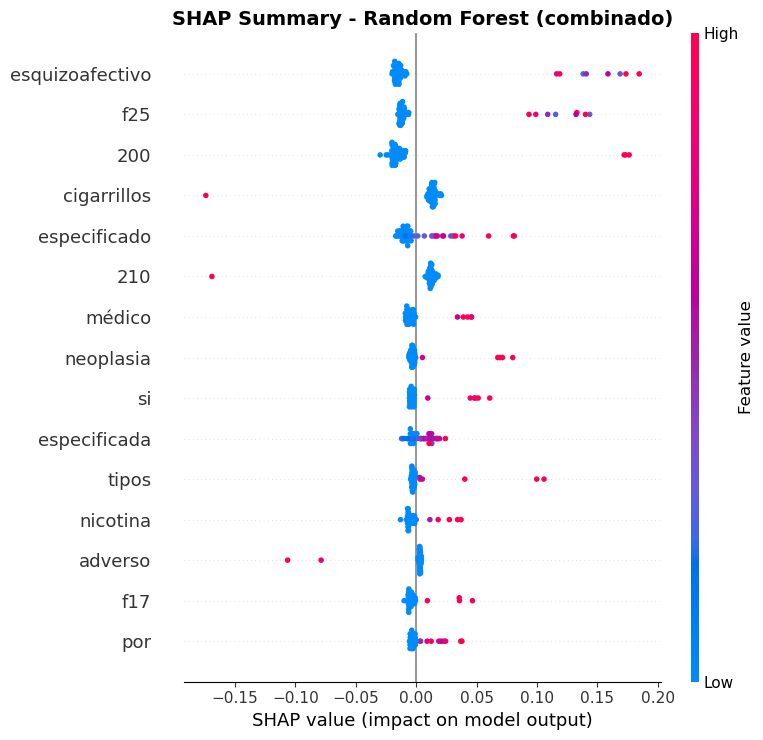

💾 Summary plot guardado en: shap_plots/combinado_Random_Forest/summary_plot.png
📊 Feature importance shape: (500,)


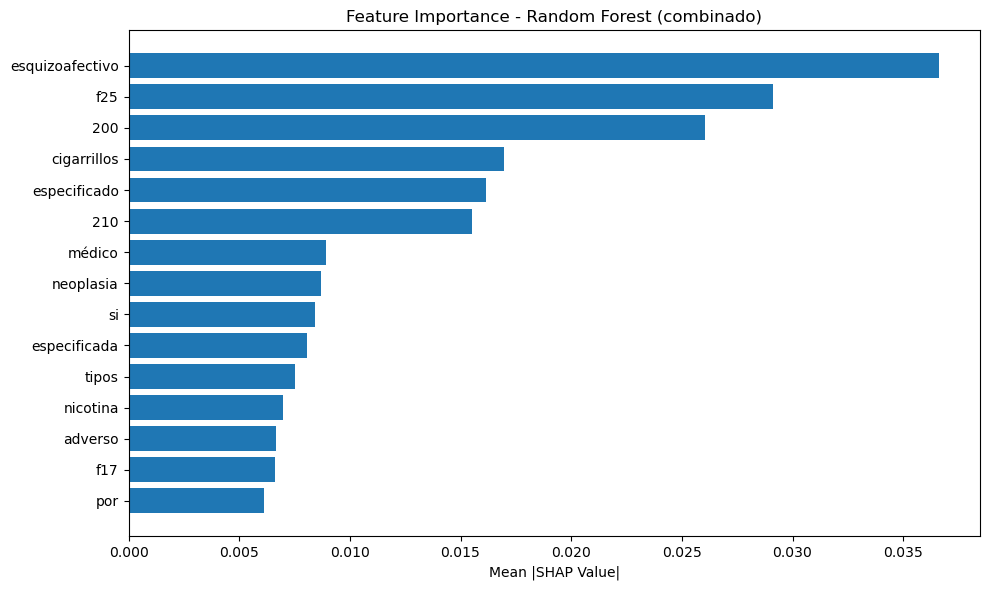

💾 Feature importance guardado en: shap_plots/combinado_Random_Forest/feature_importance.png
🌊 Generando Waterfall plots...


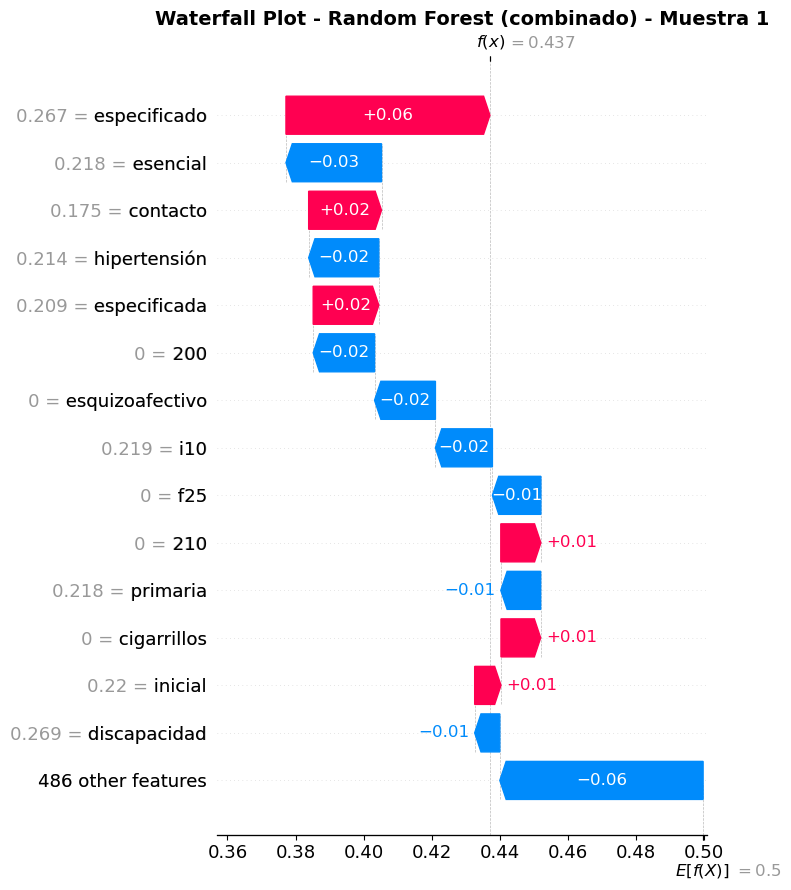

💾 Waterfall plot muestra 1 guardado en: shap_plots/combinado_Random_Forest/waterfall_sample_1.png


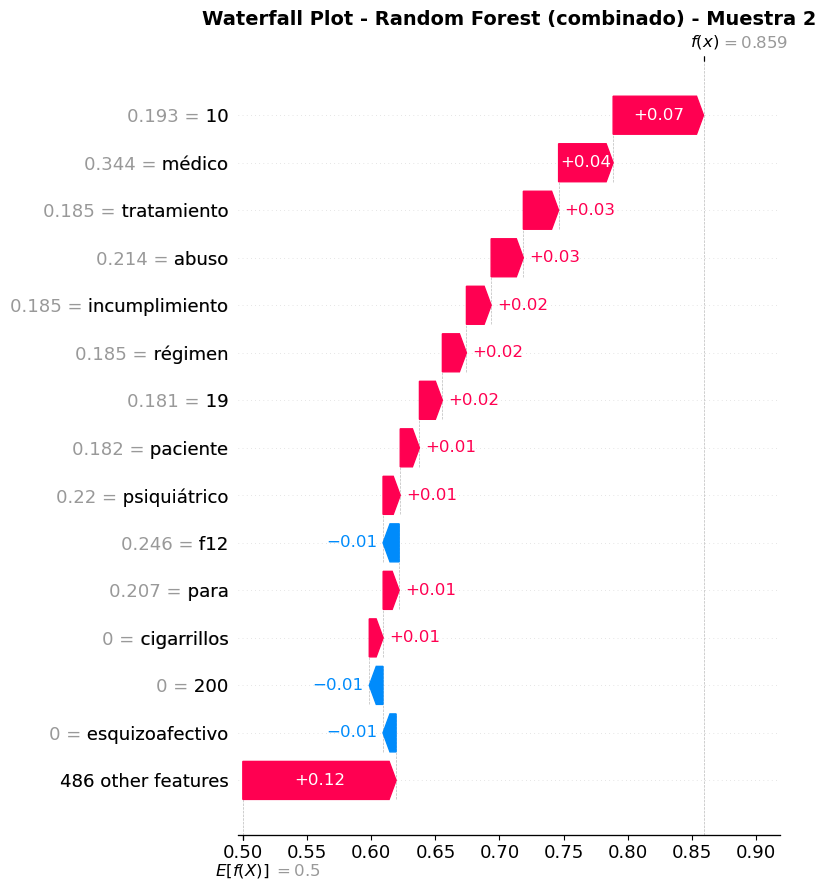

💾 Waterfall plot muestra 2 guardado en: shap_plots/combinado_Random_Forest/waterfall_sample_2.png


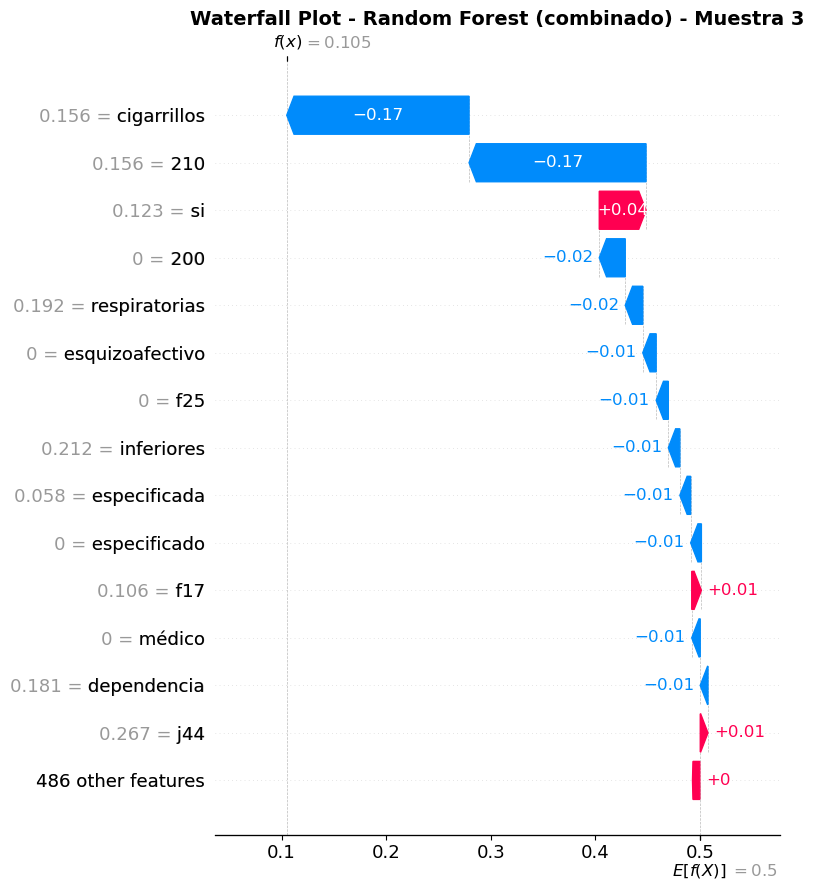

💾 Waterfall plot muestra 3 guardado en: shap_plots/combinado_Random_Forest/waterfall_sample_3.png

📌 Analizando con XGBoost en dataset: combinado
🔧 Parámetros utilizados: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 1, 'min_child_weight': 1, 'gamma': 0.1, 'scale_pos_weight': 2, 'colsample_bytree': 0.8, 'random_state': 42}
📈 Distribución de clases: {1: 1385, 0: 612}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.8075
🔎 Generando explicaciones SHAP...
📊 Forma de datos para SHAP: (50, 500), dtype: float32
📊 Background data shape: (100, 500)
📊 SHAP explanation shape: (50, 500)


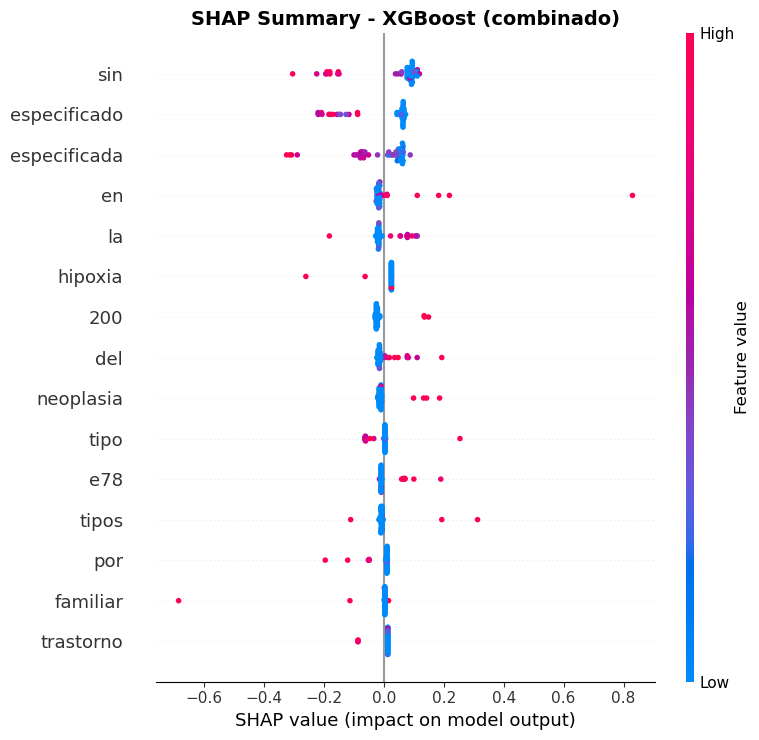

💾 Summary plot guardado en: shap_plots/combinado_XGBoost/summary_plot.png


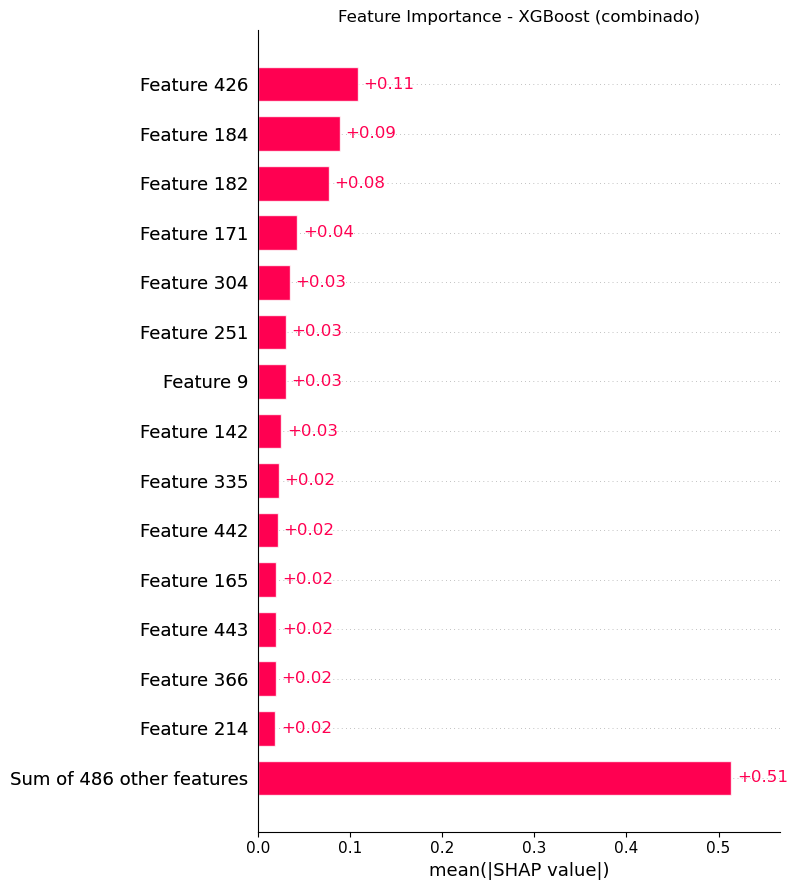

💾 Feature importance guardado en: shap_plots/combinado_XGBoost/feature_importance.png
🌊 Generando Waterfall plots...


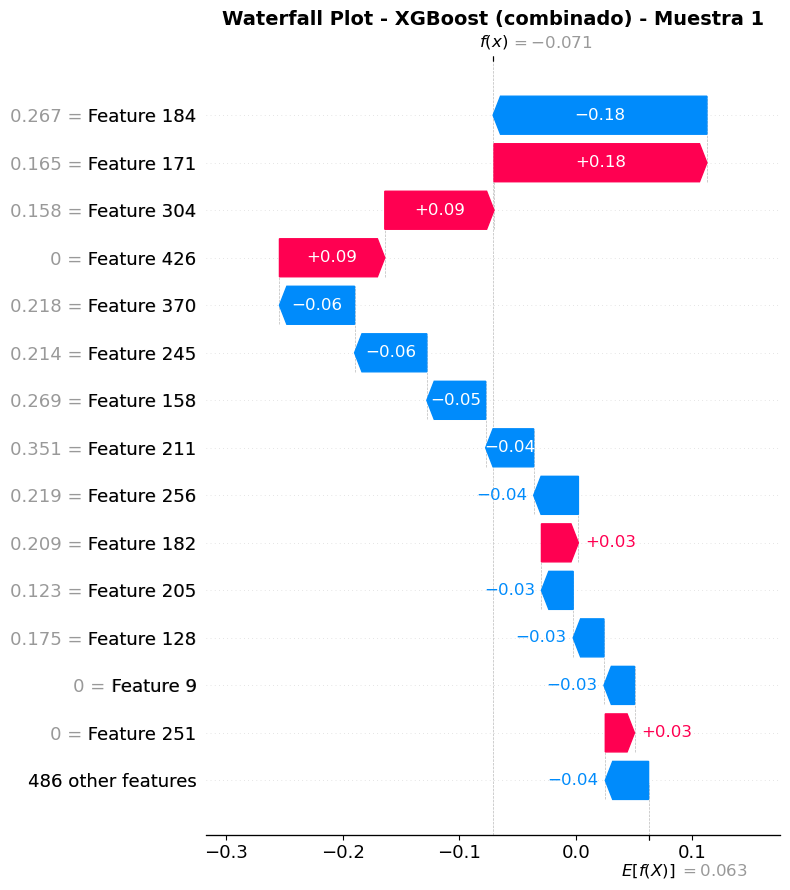

💾 Waterfall plot muestra 1 guardado en: shap_plots/combinado_XGBoost/waterfall_sample_1.png


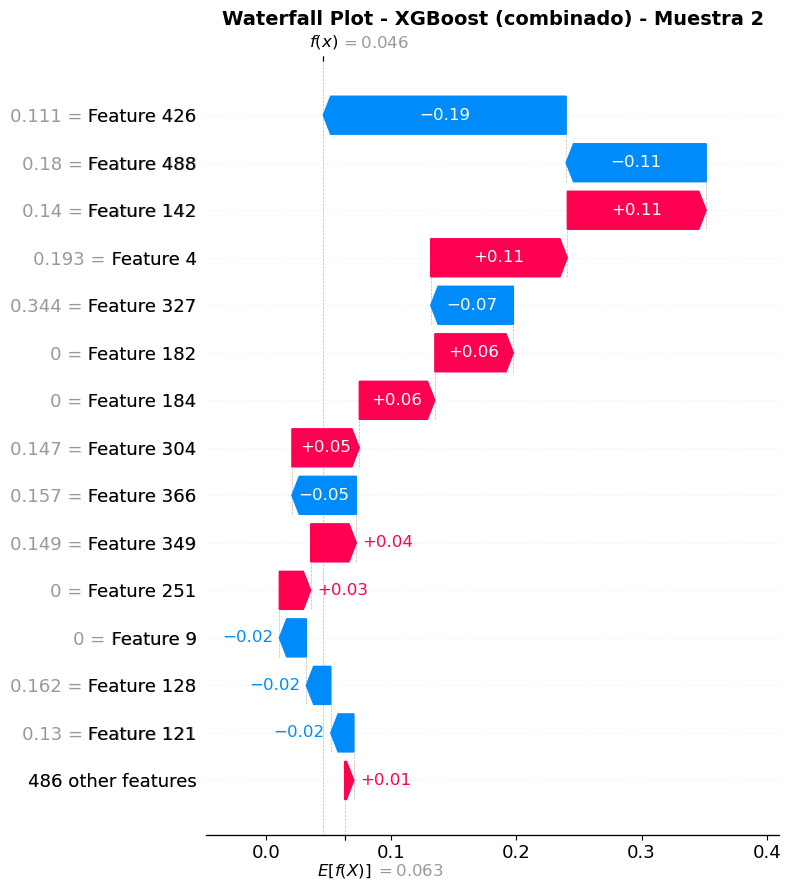

💾 Waterfall plot muestra 2 guardado en: shap_plots/combinado_XGBoost/waterfall_sample_2.png


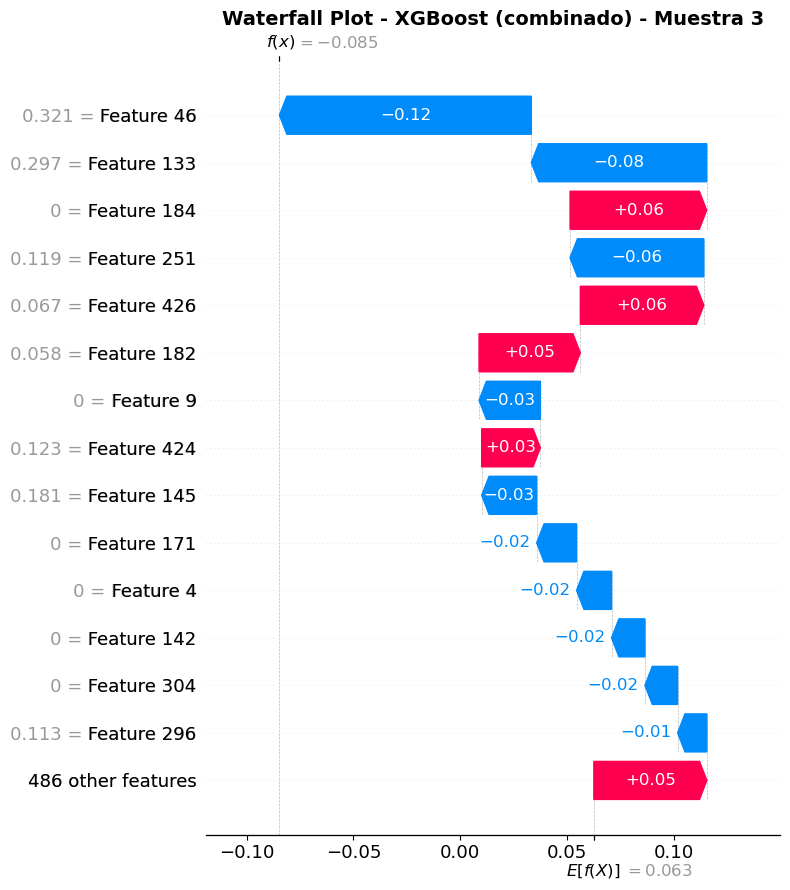

💾 Waterfall plot muestra 3 guardado en: shap_plots/combinado_XGBoost/waterfall_sample_3.png

📌 Analizando con Gradient Boosting en dataset: combinado
🔧 Parámetros utilizados: {'n_estimators': 200, 'learning_rate': 0.1, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'subsample': 1, 'max_features': None, 'random_state': 42}
📈 Distribución de clases: {1: 1385, 0: 612}
🚀 Entrenando modelo...
✅ Accuracy del modelo: 0.8025
🔎 Generando explicaciones SHAP...
📊 Forma de datos para SHAP: (50, 500), dtype: float32
📊 SHAP values tipo: <class 'numpy.ndarray'>
📊 SHAP values shape: (50, 500)
📊 Array 2D directo: (50, 500)
✅ SHAP values finales: (50, 500)


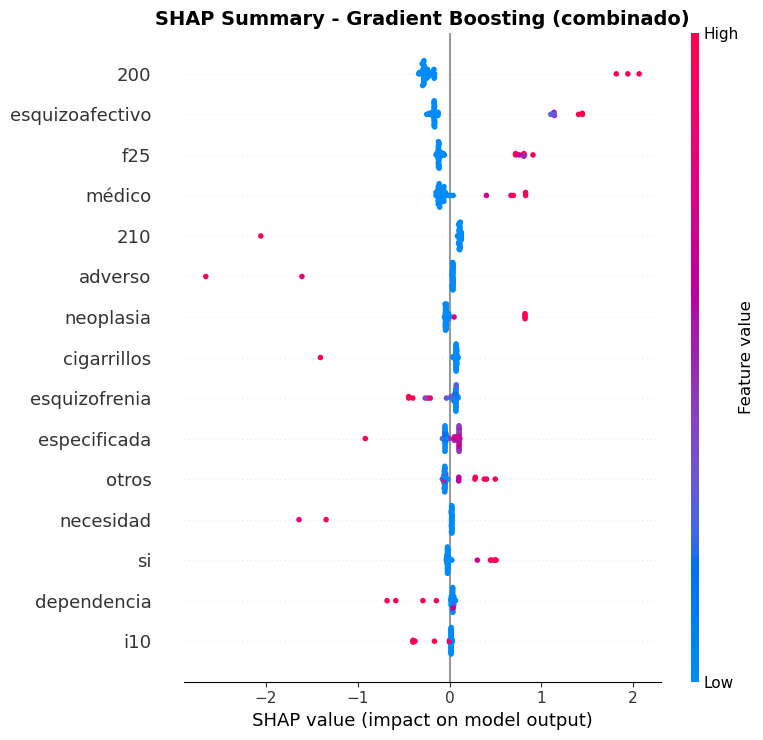

💾 Summary plot guardado en: shap_plots/combinado_Gradient_Boosting/summary_plot.png
📊 Feature importance shape: (500,)


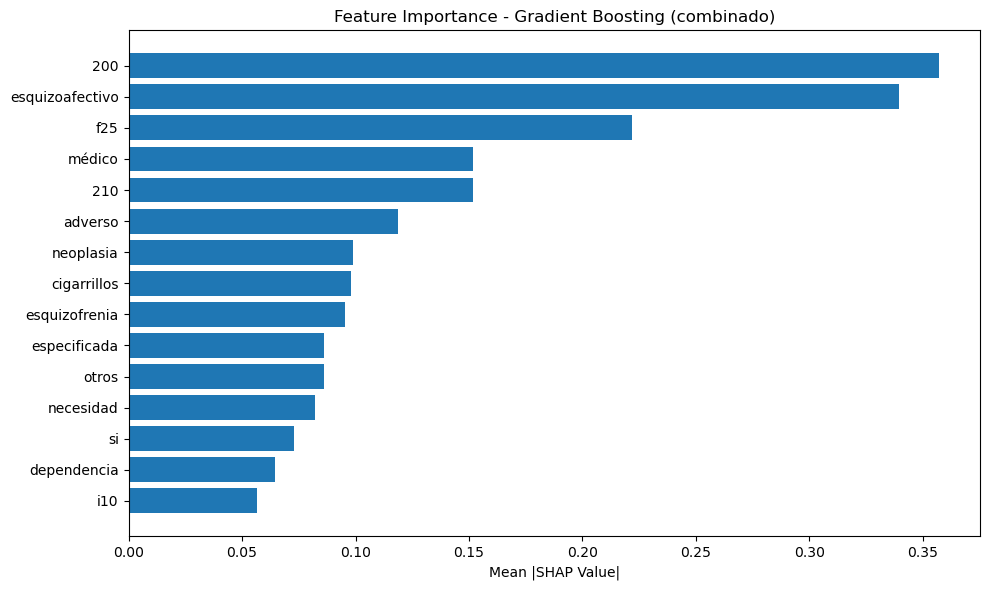

💾 Feature importance guardado en: shap_plots/combinado_Gradient_Boosting/feature_importance.png
🌊 Generando Waterfall plots...
❌ Error generando SHAP: index 1 is out of bounds for axis 0 with size 1
Tipo de error: IndexError
Detalles del error:
Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Temp\ipykernel_25396\664267579.py", line 139, in analizar_modelo_shap
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                ~~~~~~~~~~~~~~~~~~~~~~~~^^^
IndexError: index 1 is out of bounds for axis 0 with size 1


🎉 Análisis SHAP completado!


<Figure size 1200x800 with 0 Axes>

In [23]:
# Celda 5: Análisis SHAP para todos los modelos y datasets
results = {}

# Iterar sobre datasets
for dataset_name, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"🎯 PROCESANDO DATASET: {dataset_name.upper()}")
    print(f"{'='*60}")
    
    results[dataset_name] = {}
    
    # Iterar sobre modelos
    for model_key, model_class in model_classes.items():
        try:
            # Obtener parámetros específicos para este modelo y dataset
            params = all_params[dataset_name][model_key]
            model_name = model_names[model_key]
            
            # Analizar modelo
            model, accuracy = analizar_modelo_shap(
                df, dataset_name, model_class, model_name, params
            )
            
            # Guardar resultados
            results[dataset_name][model_name] = {
                "model": model,
                "accuracy": accuracy,
                "params": params
            }
            
        except KeyError as e:
            print(f"❌ No se encontraron parámetros para {model_key} en dataset {dataset_name}: {e}")
        except Exception as e:
            print(f"❌ Error procesando {model_key} en {dataset_name}: {e}")

print(f"\n🎉 Análisis SHAP completado!")

In [24]:
# Celda 6: Resumen de resultados
print("\n📊 RESUMEN DE RESULTADOS")
print("=" * 80)

for dataset_name, dataset_results in results.items():
    print(f"\n🎯 Dataset: {dataset_name.upper()}")
    print("-" * 40)
    
    if dataset_results:
        for model_name, result in dataset_results.items():
            print(f"✅ {model_name}: Accuracy = {result['accuracy']:.4f}")
    else:
        print("❌ No hay resultados disponibles")

# Encontrar el mejor modelo por dataset
print(f"\n🏆 MEJORES MODELOS POR DATASET:")
print("-" * 50)

for dataset_name, dataset_results in results.items():
    if dataset_results:
        best_model = max(dataset_results.items(), key=lambda x: x[1]['accuracy'])
        print(f"🥇 {dataset_name}: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.4f})")
    else:
        print(f"❌ {dataset_name}: No hay resultados")


📊 RESUMEN DE RESULTADOS

🎯 Dataset: CODIGOS
----------------------------------------
✅ Random Forest: Accuracy = 0.7575
✅ XGBoost: Accuracy = 0.7525
✅ Gradient Boosting: Accuracy = 0.8050

🎯 Dataset: DESCRIPCIONES
----------------------------------------
✅ Random Forest: Accuracy = 0.8200
✅ XGBoost: Accuracy = 0.8075
✅ Gradient Boosting: Accuracy = 0.8025

🎯 Dataset: COMBINADO
----------------------------------------
✅ Random Forest: Accuracy = 0.8100
✅ XGBoost: Accuracy = 0.8075
✅ Gradient Boosting: Accuracy = 0.8025

🏆 MEJORES MODELOS POR DATASET:
--------------------------------------------------
🥇 codigos: Gradient Boosting (Accuracy: 0.8050)
🥇 descripciones: Random Forest (Accuracy: 0.8200)
🥇 combinado: Random Forest (Accuracy: 0.8100)
